In [9]:
from utils import *
from transform import *

import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
loaded_data=pd.read_csv("data/movie_dataset/movie_dataset_total.csv")
loaded_data.head()

,Unnamed: 0,mid,sid,movie_id,genre,rating,plot_synopsis_len,plot_synopsis_cvt,segment_token_len,segment,...,consequence,SICA,A,IA,CA,SIA,SCA,ICA,label,split
0,0,0,0,tt0105112,"['Action', 'Thriller']",6.9,1492,1492,51,"[Jack] [Ryan] is on a ""working vacation"" in Lo...",...,not exist,0.999857,0.544908,0.002441,0.999987,0.003248,0.999941,0.999894,1,train
1,1,0,0,tt0105112,"['Action', 'Thriller']",6.9,1492,1492,51,"[Jack] [Ryan] is on a ""working vacation"" in Lo...",...,not exist,0.999874,0.999676,0.999399,0.999767,0.998795,0.999970,0.999967,1,train
2,2,0,0,tt0105112,"['Action', 'Thriller']",6.9,1492,1492,51,"[Jack] [Ryan] is on a ""working vacation"" in Lo...",...,The consequence of [mask] delivering the lect...,0.999950,0.855744,0.005276,0.999997,0.990353,0.999987,0.999915,1,train
3,3,0,0,tt0105112,"['Action', 'Thriller']",6.9,1492,1492,51,"[Jack] [Ryan] is on a ""working vacation"" in Lo...",...,not exist,0.999667,0.980863,0.000751,0.999845,0.004075,0.999872,0.999930,1,train
4,4,0,0,tt0105112,"['Action', 'Thriller']",6.9,1492,1492,51,"[Jack] [Ryan] is on a ""working vacation"" in Lo...",...,not exist,0.760265,0.106830,0.803714,0.959429,0.159387,0.849080,0.872121,-1,train


## Dynamics Calculation

In [ ]:
dynamics=[]

def average_values(data):
    value_dict = {}
    for entry in data:
        if entry[0] in value_dict:
            value_dict[entry[0]].append(entry[1])
        else:
            value_dict[entry[0]] = [entry[1]]
    
    averaged_data = [[k, sum(v)/len(v)] for k, v in value_dict.items()]
    return averaged_data

def cal_moral_dynamics(character_dict, seg_num, threshold=0.5):
    moral_dynamics = {}

    for character, segments in character_dict.items():
        count = 0
        previous_value = segments[0][1]

        for i in range(1, len(segments)):
            current_value = segments[i][1]
            
            # 이전 값과 현재 값이 threshold를 지나는지 확인
            if (previous_value < threshold and current_value > threshold) or (previous_value > threshold and current_value < threshold):
                count += 1

            previous_value = current_value

        if seg_num>1:
            moral_dynamics[character] = count / (len(segments)-1)
        else:
            moral_dynamics[character] = count / 0.1
            
    return moral_dynamics


for i in range(1,1337):
    mid=i
    movie_data=loaded_data[loaded_data['mid']==mid].reset_index(drop=True)
    
    if len(movie_data)==0: 
        continue
    else:
        #get character list
        character_list=list(set(list(movie_data['segment_char'])))
        seg_num=list(movie_data['sid'])[-1]
        
        # get characters' moral prediction per segment
        character_segment_morality_dict={key: [] for key in character_list}
        
        for i in range(len(movie_data)):
            if "no action" not in movie_data['action'][i]:
                character_segment_morality_dict[movie_data['segment_char'][i]].append([movie_data['sid'][i], movie_data['SICA'][i]])

        # Store the average value when a character appears multiple times in a segment.
        for character in character_segment_morality_dict:
            character_segment_morality_dict[character] = average_values(character_segment_morality_dict[character])

        # Remove characters that appear fewer than 3 times.
        character_segment_morality_dict = {k: v for k, v in character_segment_morality_dict.items() if len(v) > 2}
        
        # Calculate moral dynamics
        moral_dynamics = cal_moral_dynamics(character_segment_morality_dict, seg_num)
        
        if len(moral_dynamics) !=0:
            avg_dynamic= max(moral_dynamics.values())
        else:
            avg_dynamics=0
        
        dynamics.append({
            'mid': mid,
            'rating': list(movie_data['rating'])[0],
            'segment_num': seg_num,
            'movie_id': list(movie_data['movie_id'])[0],
            'genre': list(movie_data['genre'])[0].strip('[').strip(']').replace("'","").replace(" ","").split(","),
            'character_segment_morality_dict': character_segment_morality_dict,
            'moral_dynamics_dict': moral_dynamics,
            'average_dynamices': avg_dynamic
        })
        
dynamics[0]

{'mid': 1,
 'rating': 6.6,
 'segment_num': 11,
 'movie_id': 'tt1204975',
 'genre': ['Comedy'],
 'character_segment_morality_dict': {'Billy': [[2, 0.502481803],
   [3, 0.3311601416753333],
   [4, 0.9991461],
   [5, 0.9998614],
   [6, 0.999984285],
   [7, 0.00048941106],
   [8, 0.49998662476635003],
   [9, 0.9999866],
   [10, 6.7498186e-05]],
  'Archie': [[1, 0.9945783],
   [2, 0.013773775],
   [4, 0.99995272],
   [6, 0.99983865],
   [7, 0.9999866],
   [10, 0.009852506]],
  'Sam': [[1, 0.99167377],
   [2, 0.50028527823],
   [3, 0.9999609],
   [6, 0.9998799],
   [7, 0.0007568271],
   [11, 1.4347544e-05]],
  'Diana': [[3, 0.6665300805833333],
   [4, 0.99907583],
   [5, 0.001030842],
   [8, 1.2311187e-05]]},
 'moral_dynamics_dict': {'Billy': 0.625,
  'Archie': 0.6,
  'Sam': 0.2,
  'Diana': 0.3333333333333333},
 'average_dynamices': 0.625}

## 1. Analysis the rate of dynamic characters per genre 

In [ ]:
genre_list=["Drama","Comedy","Action",'Adventure','Crime','Thriller','Romance','Sci-Fi','Fantasy','Mystery','Family','Horror','Biography','Animation','History','Sport','Music','War','Musical','Western','Film-Noir']

# genre 별

for genre in genre_list:
    rating=[]
    total_story_num=0
    total_char_num=0
    main_char_dynamics=[]
    total_char_dynamics=0
    
    for i in range(len(dynamics)):
        if genre in dynamics[i]['genre']:
            rating.append(dynamics[i]['rating'])
            total_story_num+=1
            
            # main character dynamics
            character_dict=dynamics[i]['character_segment_morality_dict']
            moral_dynamics_dict=dynamics[i]['moral_dynamics_dict']
            total_char_num+=len(character_dict)
            
            values=[x for x in list(moral_dynamics_dict.values()) if x >=0.5]
            
            if len(moral_dynamics_dict)!=0: 
            
                if len(values)/len(moral_dynamics_dict) >=0.5:
                    total_char_dynamics+=1

            if len(character_dict)==0: continue
            else:
                main_character= max(character_dict, key=lambda k: len(character_dict[k]))
                main_char_dynamics.append(dynamics[i]['moral_dynamics_dict'][main_character])
    
    # The number of stories where the main character dynamics are 0.5 or higher.
    tmp=[x for x in main_char_dynamics if x >=0.5]
    
    print(f"=> genre: {genre}")
    print(f"The number of stories where the dynamic character rate is 0.5 or higher. : {total_char_dynamics}")
    print(f"The number of stories where the dynamic main character rate is 0.5 or higher. : {len(tmp)}")
    print(f"The Agerate Rating : {sum(rating)/len(rating)}")
    print("**********************")

=> genre: Drama
The number of stories where the dynamic character rate is 0.5 or higher. : 371
The number of stories where the dynamic main character rate is 0.5 or higher. : 284
The Agerate Rating : 7.471005917159758
**********************
=> genre: Comedy
The number of stories where the dynamic character rate is 0.5 or higher. : 238
The number of stories where the dynamic main character rate is 0.5 or higher. : 157
The Agerate Rating : 6.850246305418713
**********************
=> genre: Action
The number of stories where the dynamic character rate is 0.5 or higher. : 255
The number of stories where the dynamic main character rate is 0.5 or higher. : 200
The Agerate Rating : 6.8657289002557595
**********************
=> genre: Adventure
The number of stories where the dynamic character rate is 0.5 or higher. : 239
The number of stories where the dynamic main character rate is 0.5 or higher. : 186
The Agerate Rating : 7.031088082901561
**********************
=> genre: Crime
The number of

## 2. Moral Dynamic Characters

In [27]:
def draw_dynamics_characters(mid):
    for i in range(len(dynamics)):
        if dynamics[i]['mid']==mid:
            #mid=dynamics[i]['movie_id']
            data=dynamics[i]['moral_dynamics_dict']
            genre=dynamics[i]['genre']

    keys = list(data.keys())
    values = list(data.values())
    
    colors = ['red' if value >= 0.5 else 'darkblue' for value in values]

    plt.figure(figsize=(4, 2))
    plt.scatter(keys, values, color=colors, s=80)

    plt.title(f'{mid} | {genre} ', fontsize=13)

    plt.ylabel('Dynamics')
    plt.axhline(y=0.5, color='r', linestyle='--')
    plt.ylim(0, 1)

    plt.xticks(rotation=45, ha='right')
    plt.xticks(fontsize=13)  # Increase x-axis font size
    plt.yticks(fontsize=14)  # Increase y-axis font size

    plt.show()

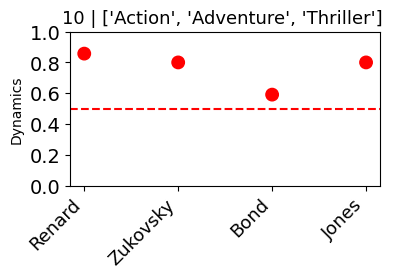

In [28]:
draw_dynamics_characters(10)

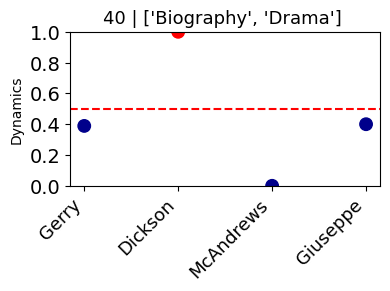

In [29]:
draw_dynamics_characters(40)

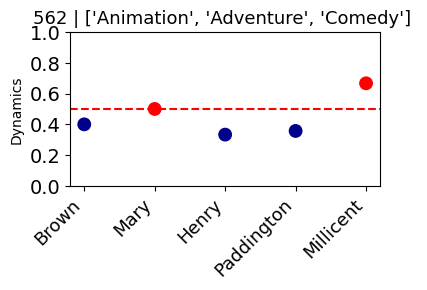

In [30]:
draw_dynamics_characters(562)

## 3. Characters' Moral Dynamics Flow Graph

In [55]:
def draw_moral_dynamics_flow(mid):
    for i in range(len(dynamics)):
        if dynamics[i]['mid']==mid:
            genre=dynamics[i]['genre']
            rating=dynamics[i]['rating']
            character_segment_morality_dict=dynamics[i]['character_segment_morality_dict']
            
    # Prepare the data for plotting
    plot_data = []
    for character, values in character_segment_morality_dict.items():
        for segment, morality in values:
            plot_data.append([segment, character, morality])

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame(plot_data, columns=['segment', 'character', 'morality'])

    # Determine the number of characters
    num_characters = len(character_segment_morality_dict)

    # Create subplots
    fig, axs = plt.subplots(num_characters, 1, figsize=(10, 7), sharex=True)

    if num_characters == 1:
        axs = [axs]  # Ensure axs is always a list, even if there's only one character

    # Plotting each character in its own subplot
    colors = plt.cm.tab10(range(num_characters))

    for ax, (character, color) in zip(axs, zip(character_segment_morality_dict.keys(), colors)):
        character_data = plot_df[plot_df['character'] == character]
        
        if not character_data.empty:
            ax.plot(character_data['segment'], character_data['morality'], marker='o', label=character, color=color, linewidth=2)
            #ax.set_title(character)
            ax.set_ylabel('Morality', fontsize=10)
            #ax.yticks(fontsize=35)
            ax.axhline(y=0.5, color='r', linestyle='--')
            ax.set_ylim(-0.1, 1.1)
            plt.xticks(fontsize=10)  # Increase x-axis font size
            plt.yticks(fontsize=10)  # Increase y-axis font size
            ax.legend(fontsize=10)

    # Set common labels
    plt.xlabel('Segment', fontsize=10)
    plt.suptitle(f'{mid}: rating {rating}', y=1, fontsize=15)
    plt.tight_layout()
    plt.show()


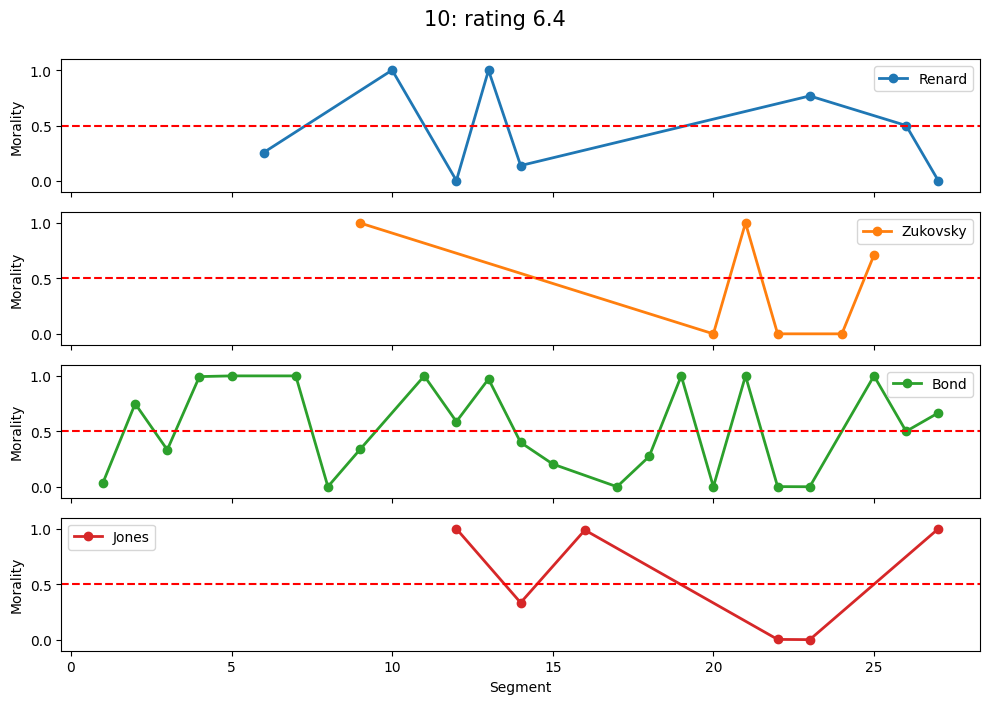

In [56]:
draw_moral_dynamics_flow(10)

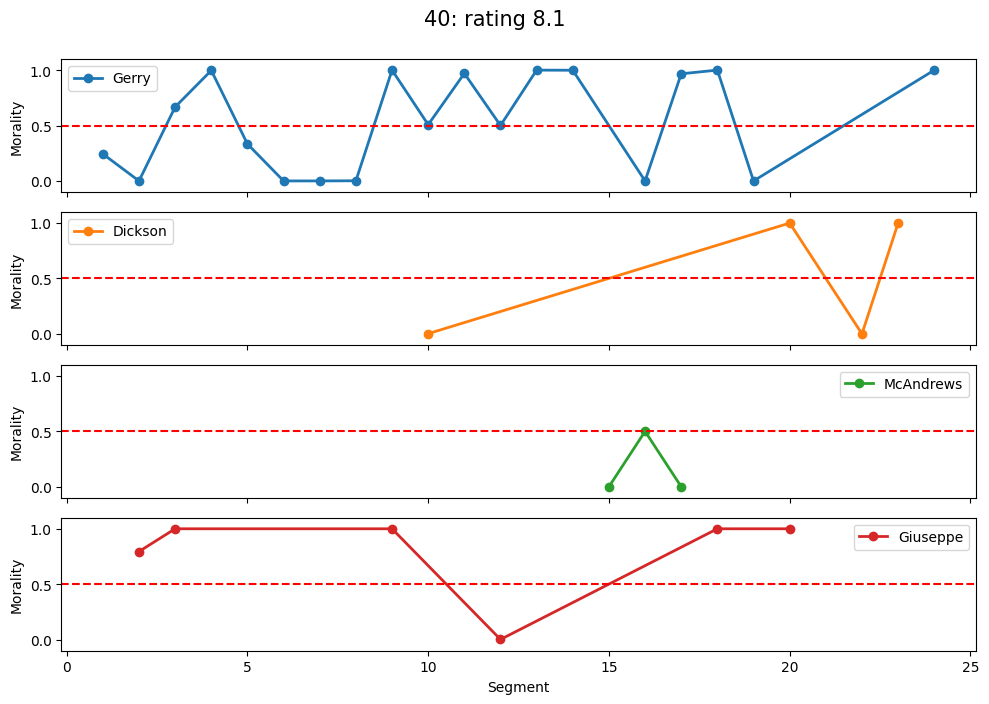

In [57]:
draw_moral_dynamics_flow(40)

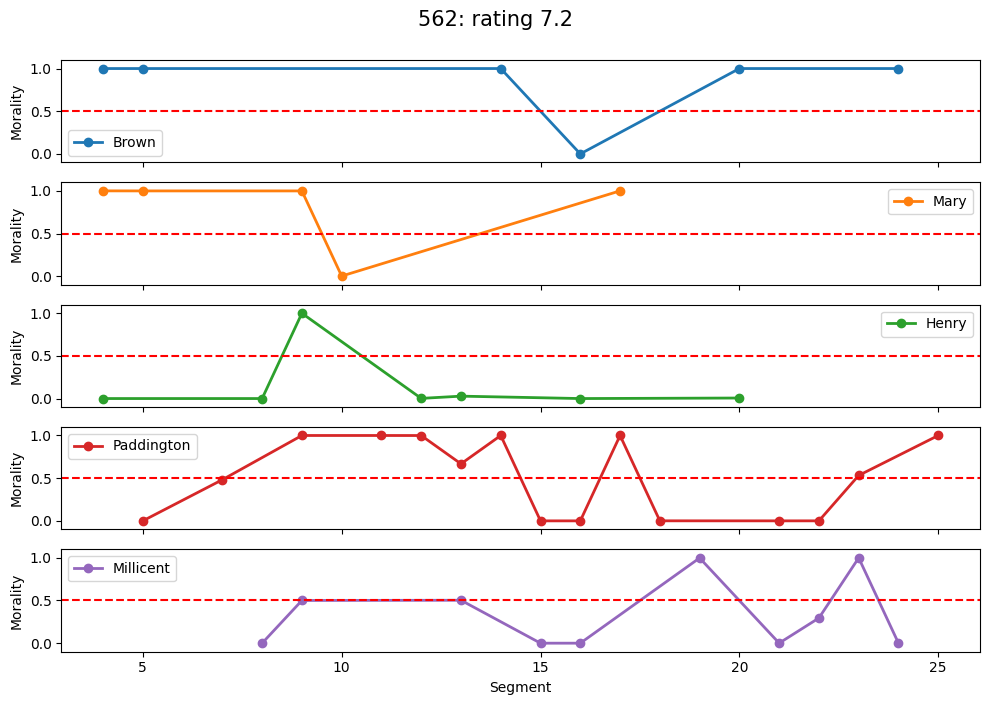

In [58]:
draw_moral_dynamics_flow(562)